In [1]:
import os
import tarfile
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, RandomCrop, ToTensor, Resize, ToPILImage

In [2]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['bmp', '.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

class DatasetFromfolder(Dataset):
    def __init__(self, path):
        super(DatasetFromfolder, self).__init__()
        self.filenames = []
        folders = os.listdir(path)
        for f in folders:
            self.filenames.append(path + f)
        self.data_transform = Compose([RandomCrop([33, 33]), ToTensor()])
        self.data_transform_PIL = Compose([ToPILImage()])

    def __getitem__(self, index):        
        w = h = 512
        img = Image.open(self.filenames[index])
        img, _cb, _cr = img.convert('YCbCr').split()     
        img = self.data_transform(img)           
        result_image = img
        
        resize_image = self.data_transform_PIL(img)        
        resize_image = resize_image.resize((int(w/4), int(h/4)))
        resize_image = resize_image.resize((w, h), Image.BICUBIC)
        resize_image = self.data_transform(resize_image) 
        
        return result_image, resize_image

    def __len__(self):
        return len(self.filenames)

In [3]:
root_dir = '../input/btdataset/processed_images/'

In [4]:
test_path_normal = os.path.join(root_dir, "test")

test_img_normal_paths = sorted(
    [
        os.path.join(test_path_normal, fname)
        for fname in os.listdir(test_path_normal)
        if fname.endswith(".jpeg")
    ]
)

In [5]:
# test_path_pneumonia = os.path.join(root_dir, "test/PNEUMONIA")

# test_img_pneumonia_paths = sorted(
#     [
#         os.path.join(test_path_pneumonia, fname)
#         for fname in os.listdir(test_path_pneumonia)
#         if fname.endswith(".jpeg")
#     ]
# )

In [6]:
class SuperResolutionCNN(nn.Module):
    def __init__(self):
        super(SuperResolutionCNN, self).__init__()
        self.Conv1 = nn.Conv2d(1, 64, 9, 1, 4)
        self.Conv2 = nn.Conv2d(64, 32, 3, 1, 1)
        self.Conv3 = nn.Conv2d(32, 1, 5, 1, 2)
        self.Relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = self.Relu(self.Conv1(x))
        out = self.Relu(self.Conv2(out))
        out = self.Conv3(out)
        return out

In [12]:
data_transform = Compose([ToTensor()])    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_set = DatasetFromfolder('../input/btdataset/processed_images/train/')
train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=64, shuffle=True)

SRCNN = SuperResolutionCNN()
if torch.cuda.device_count() > 1:
    SRCNN = nn.DataParallel(SRCNN)
SRCNN.to(device)    

optimizer = optim.Adam(SRCNN.parameters())
criterion = nn.MSELoss().to(device)

new_point = 0
os.system('mkdir /tmp/checkpoint')
os.system('mkdir /tmp/image')

256

In [15]:
def train(NUM_EPOCHS=1):
    #NUM_EPOCHS = 10 #501
#     data_transform = Compose([ToTensor()])    
    
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     train_set = DatasetFromfolder('../input/xray-normal/xray_dataset_normal/train/')
#     train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=64, shuffle=True)
    
#     SRCNN = SuperResolutionCNN()
#     if torch.cuda.device_count() > 1:
#         SRCNN = nn.DataParallel(SRCNN)
#     SRCNN.to(device)    
    
#     optimizer = optim.Adam(SRCNN.parameters())
#     criterion = nn.MSELoss().to(device)
    
    new_point = 0
#     os.system('mkdir checkpoint')
#     os.system('mkdir image')
    
    for epoch in range(NUM_EPOCHS+1):        
        batch_idx = 0        
        for HR, LR in train_loader:
            HR = HR.to(device)
            LR = LR.to(device)            
            newHR = SRCNN(LR) 
            
            SRCNN.train()
            SRCNN.zero_grad()
            loss = criterion(HR, newHR)
            loss.backward(retain_graph=True)
            optimizer.step()
            
            if epoch%100==0 and batch_idx%1==0:
                SRCNN.eval()
                print("Epoch:{} batch[{}/{}] loss:{}".format(epoch, batch_idx, len(train_loader), loss))      
                
                img = Image.open('../input/btdataset/processed_images/valid/IMG_804.jpeg')   
                            
                w, h = img.size
                
                result_image = img
                result_image_y, _cb, _cr = result_image.convert('YCbCr').split()
                result_image_y = data_transform(result_image_y)   
        
                resize_image = img.resize((int(w/3), int(h/3)), Image.BICUBIC)       
                resize_image = resize_image.resize((w, h), Image.BICUBIC)
                resize_image_y, _cb, _cr = resize_image.convert('YCbCr').split()
                resize_image_y = data_transform(resize_image_y).to(device)
                newHR = SRCNN(resize_image_y.unsqueeze(0))
                
                torchvision.utils.save_image(resize_image_y, f'/tmp/image/LR{epoch}.png')
                torchvision.utils.save_image(result_image_y, f'/tmp/image/HR{epoch}.png')
                torchvision.utils.save_image(newHR, f'/tmp/image/newHR{epoch}.png')
                
                im1 = Image.open(f'/tmp/image/LR{epoch}.png')
                im2 = Image.open(f'/tmp/image/HR{epoch}.png')
                im3 = Image.open(f'/tmp/image/newHR{epoch}.png')                
                dst = Image.new('RGB', (w*3 , h))
                dst.paste(im1, (0, 0))
                dst.paste(im2, (w, 0))
                dst.paste(im3, (w*2, 0))
                dst.save(f'/tmp/image/image{epoch}.png')
                img = Image.open(f'/tmp/image/image{epoch}.png')
                plt.imshow(img)
                plt.title(f'Image After {epoch} epochs')
                plt.show()
                
            batch_idx += 1
            
        torch.save(SRCNN.state_dict(), '/tmp/checkpoint/ckpt_%d.pth' % (new_point))
        new_point += 1

Epoch:0 batch[0/10] loss:0.01816674694418907


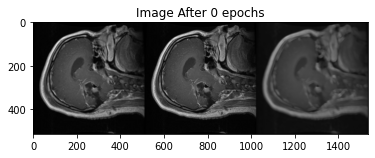

Epoch:0 batch[1/10] loss:0.013981509953737259


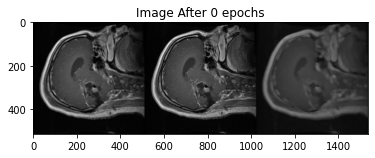

Epoch:0 batch[2/10] loss:0.015290605835616589


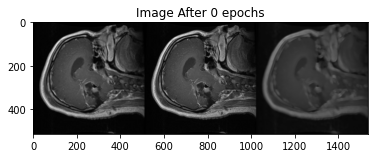

Epoch:0 batch[3/10] loss:0.01731755957007408


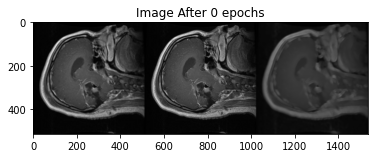

Epoch:0 batch[4/10] loss:0.016641657799482346


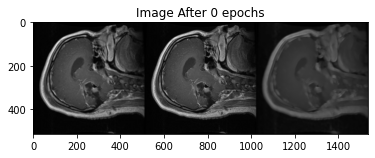

Epoch:0 batch[5/10] loss:0.024636516347527504


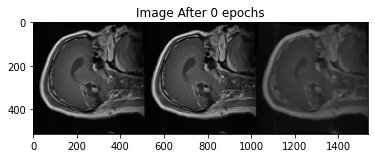

Epoch:0 batch[6/10] loss:0.012470772489905357


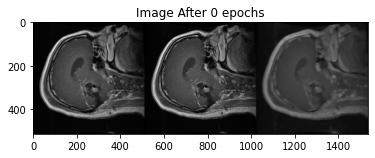

Epoch:0 batch[7/10] loss:0.015867700800299644


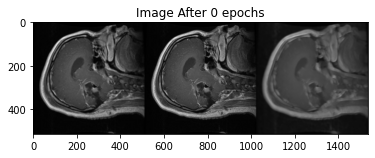

Epoch:0 batch[8/10] loss:0.012300713919103146


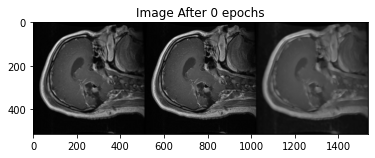

Epoch:0 batch[9/10] loss:0.022107485681772232


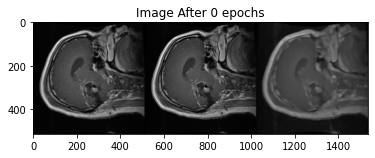

Epoch:100 batch[0/10] loss:0.01381519716233015


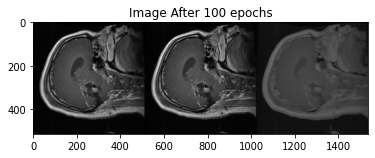

Epoch:100 batch[1/10] loss:0.012512493878602982


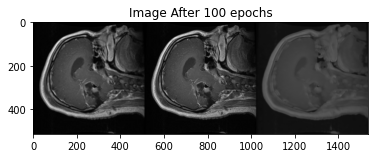

Epoch:100 batch[2/10] loss:0.01671591028571129


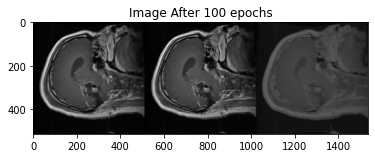

Epoch:100 batch[3/10] loss:0.015124805271625519


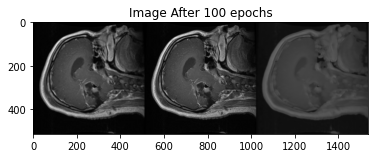

Epoch:100 batch[4/10] loss:0.012325765565037727


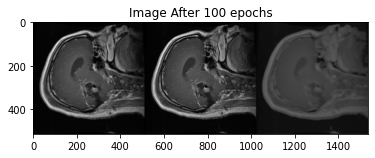

Epoch:100 batch[5/10] loss:0.014203201979398727


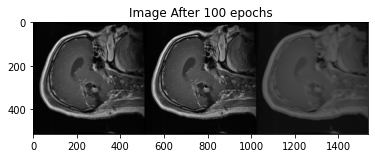

Epoch:100 batch[6/10] loss:0.016003895550966263


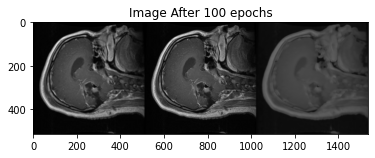

Epoch:100 batch[7/10] loss:0.011538306251168251


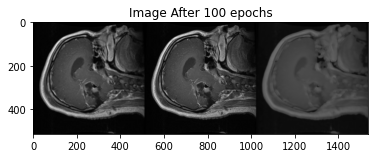

Epoch:100 batch[8/10] loss:0.01243057381361723


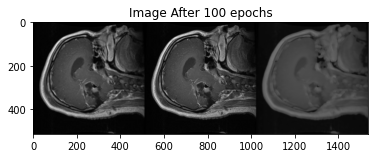

Epoch:100 batch[9/10] loss:0.013952463865280151


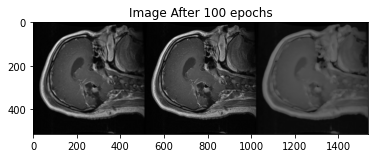

Epoch:200 batch[0/10] loss:0.014721764251589775


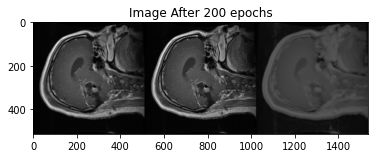

Epoch:200 batch[1/10] loss:0.012118418700993061


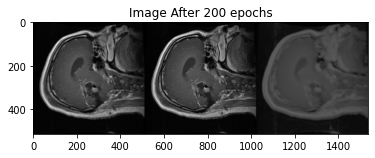

Epoch:200 batch[2/10] loss:0.015946095809340477


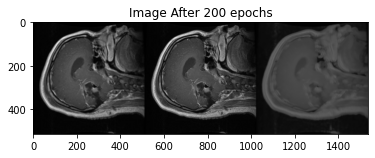

Epoch:200 batch[3/10] loss:0.012911357916891575


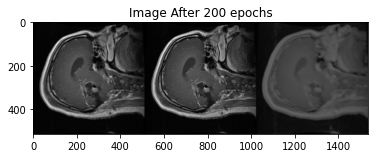

Epoch:200 batch[4/10] loss:0.012573075480759144


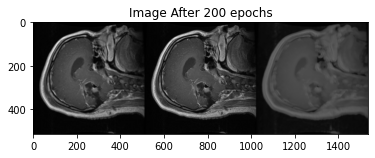

Epoch:200 batch[5/10] loss:0.016987621784210205


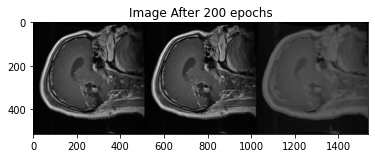

Epoch:200 batch[6/10] loss:0.01799311675131321


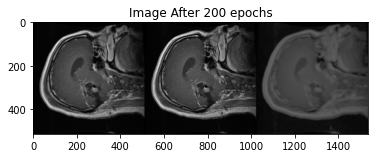

Epoch:200 batch[7/10] loss:0.017527595162391663


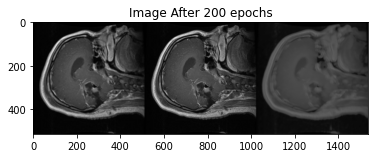

Epoch:200 batch[8/10] loss:0.01857808791100979


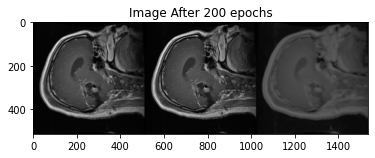

Epoch:200 batch[9/10] loss:0.026921836659312248


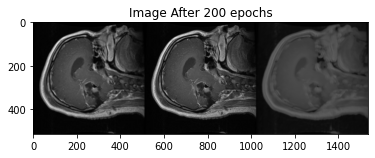

In [16]:
n_epochs=200
train(NUM_EPOCHS=n_epochs)

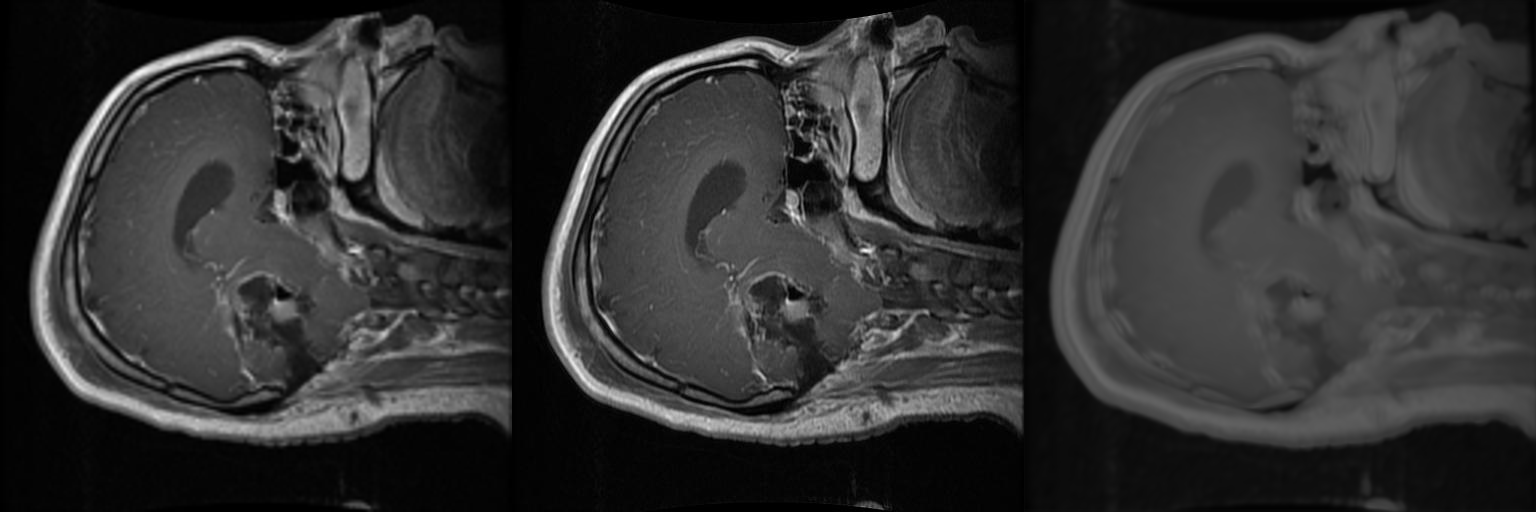

In [17]:
Image.open(f'/tmp/image/image{n_epochs}.png')

In [18]:
# from IPython.display import FileLink
#FileLink('./image/image.png')
#FileLink('./image/LR.png')
#FileLink('./image/HR.png')
#FileLink('./image/newHR.png')

In [19]:
os.system('mkdir /tmp/HR_imgs')
os.system('mkdir /tmp/SR_imgs')

0

In [ ]:
os.system('mkdir /tmp/HR_NORMAL_imgs')
os.system('mkdir /tmp/SR_NORMAL_imgs')

In [20]:
# total_bicubic_psnr = 0.0
# total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_normal_paths[:]):
    #print("Epoch:{} batch[{}/{}] loss:{}".format(epoch+1, batch_idx+1, len(train_loader), loss))    
    
    data_transform = Compose([ToTensor()])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img = Image.open(test_img_path)   

    w, h = img.size

    result_image = img
    result_image_y, _cb, _cr = result_image.convert('YCbCr').split()
    result_image_y = data_transform(result_image_y)   

    resize_image = img.resize((int(w/3), int(h/3)), Image.BICUBIC)       
    resize_image = resize_image.resize((w, h), Image.BICUBIC)
    resize_image_y, _cb, _cr = resize_image.convert('YCbCr').split()
    resize_image_y = data_transform(resize_image_y).to(device)
    newHR = SRCNN(resize_image_y.unsqueeze(0))
    
#     plot_results(resize_image_y, index, "lowres")
#     plot_results(result_image_y, index, "highres")
#     plot_results(newHR, index, "prediction")

#     torchvision.utils.save_image(resize_image_y, f'./output/LR{index+1}.png')
    torchvision.utils.save_image(result_image_y, f'/tmp/HR_imgs/HR{index+1}.png')
    torchvision.utils.save_image(newHR, f'/tmp/SR_imgs/newHR{index+1}.png')

#     im1 = Image.open(f'./output/LR{index+1}.png')
#     im2 = Image.open(f'./output/HR{index+1}.png')
#     im3 = Image.open(f'./output/newHR{index+1}.png')                
#     dst = Image.new('RGB', (w*3 , h))
#     dst.paste(im1, (0, 0))
#     dst.paste(im2, (w, 0))
#     dst.paste(im3, (w*2, 0))
    
#     dst.save(f'./output/image{index+1}.png')
#     img = Image.open(f'./output/image{index+1}.png')
#     plt.imshow(img)
#     plt.title(f'Test Image {index+1}')
#     plt.show()

In [21]:
%%!

zip -r HR_imgs.zip /tmp/HR_imgs

['  adding: tmp/HR_imgs/ (stored 0%)',
 '  adding: tmp/HR_imgs/HR118.png (deflated 2%)',
 '  adding: tmp/HR_imgs/HR186.png (deflated 0%)',
 '  adding: tmp/HR_imgs/HR171.png (deflated 0%)',
 '  adding: tmp/HR_imgs/HR146.png (deflated 0%)',
 '  adding: tmp/HR_imgs/HR25.png (deflated 1%)',
 '  adding: tmp/HR_imgs/HR48.png (deflated 0%)',
 '  adding: tmp/HR_imgs/HR43.png (deflated 1%)',
 '  adding: tmp/HR_imgs/HR101.png (deflated 1%)',
 '  adding: tmp/HR_imgs/HR177.png (deflated 0%)',
 '  adding: tmp/HR_imgs/HR125.png (deflated 1%)',
 '  adding: tmp/HR_imgs/HR58.png (deflated 0%)',
 '  adding: tmp/HR_imgs/HR142.png (deflated 1%)',
 '  adding: tmp/HR_imgs/HR67.png (deflated 0%)',
 '  adding: tmp/HR_imgs/HR174.png (deflated 0%)',
 '  adding: tmp/HR_imgs/HR121.png (deflated 0%)',
 '  adding: tmp/HR_imgs/HR16.png (deflated 0%)',
 '  adding: tmp/HR_imgs/HR47.png (deflated 1%)',
 '  adding: tmp/HR_imgs/HR145.png (deflated 0%)',
 '  adding: tmp/HR_imgs/HR169.png (deflated 2%)',
 '  adding: tmp/HR

In [22]:
%%!

zip -r SR_imgs.zip /tmp/SR_imgs

['  adding: tmp/SR_imgs/ (stored 0%)',
 '  adding: tmp/SR_imgs/newHR132.png (deflated 0%)',
 '  adding: tmp/SR_imgs/newHR103.png (deflated 2%)',
 '  adding: tmp/SR_imgs/newHR119.png (deflated 0%)',
 '  adding: tmp/SR_imgs/newHR120.png (deflated 1%)',
 '  adding: tmp/SR_imgs/newHR4.png (deflated 0%)',
 '  adding: tmp/SR_imgs/newHR198.png (deflated 0%)',
 '  adding: tmp/SR_imgs/newHR3.png (deflated 0%)',
 '  adding: tmp/SR_imgs/newHR192.png (deflated 2%)',
 '  adding: tmp/SR_imgs/newHR9.png (deflated 0%)',
 '  adding: tmp/SR_imgs/newHR137.png (deflated 0%)',
 '  adding: tmp/SR_imgs/newHR39.png (deflated 0%)',
 '  adding: tmp/SR_imgs/newHR130.png (deflated 0%)',
 '  adding: tmp/SR_imgs/newHR74.png (deflated 2%)',
 '  adding: tmp/SR_imgs/newHR166.png (deflated 0%)',
 '  adding: tmp/SR_imgs/newHR139.png (deflated 2%)',
 '  adding: tmp/SR_imgs/newHR149.png (deflated 2%)',
 '  adding: tmp/SR_imgs/newHR2.png (deflated 2%)',
 '  adding: tmp/SR_imgs/newHR188.png (deflated 0%)',
 '  adding: tmp/S

In [ ]:
# %%!

# zip -r HR_PNEUMONIA_imgs.zip /tmp/HR_PNEUMONIA_imgs

In [ ]:
# %%!

# zip -r SR_PNEUMONIA_imgs.zip /tmp/SR_PNEUMONIA_imgs